In [ ]:
import pandas as pd
import numpy as np
from semopy import Model

# 模擬データの生成
np.random.seed(0)
n_samples = 100
X1 = np.random.normal(0, 1, n_samples)  # ルール改正
X2 = 0.5 * X1 + np.random.normal(0, 1, n_samples)  # 試合時間
Y = 0.3 * X2 + np.random.normal(0, 1, n_samples)  # 観客者数
data = pd.DataFrame({'RuleChange': X1, 'GameDuration': X2, 'Attendance': Y})

# SEMモデルの定義
model_desc = """
# 回帰関係
GameDuration ~ RuleChange
Attendance ~ GameDuration

# 共分散
RuleChange ~~ RuleChange
GameDuration ~~ GameDuration
Attendance ~~ Attendance
"""

# モデルの構築と推定
model = Model(model_desc)
results = model.fit(data)
print(model.inspect())


In [ ]:
import pandas as pd
import numpy as np
from preprocess import Att_Analysis

In [ ]:
# 以上の処理を関数化
def prepare_df():
    """
    monthly_average_game_time.csvとmonthly_all.csvを結合する
    """
    att_remove_covid_addup = Att_Analysis(is_remove_covid=True, is_addup=True)
    att_df = att_remove_covid_addup.get_monthly_all_df()
    game_df = pd.read_csv('./data/monthly_average_game_time.csv')

    att_df.reset_index(inplace=True)
    att_df.rename(columns={'index': 'date'}, inplace=True)

    # game_dfのindexをatt_dfに合わせる
    game_df =game_df.set_index('Unnamed: 0').rename_axis('date').reset_index()
    # game_dfのdateを変換
    game_df['date'] = pd.to_datetime(game_df['date'], format='%Y/%m/1')
    # 日付はいらない。月だけでいい
    game_df['date'] = game_df['date'].dt.strftime('%Y-%m')

    # データの結合
    df = pd.merge(att_df, game_df, on='date')
    
    # Rule Change列を追加
    # 2023-04から1、それ以前は0
    df['RuleChange'] = 0
    df.loc[df['date'] >= '2023-04', 'RuleChange'] = 1
    return df

In [ ]:
# 経路分析を行う
import statsmodels.api as sm
import statsmodels.formula.api as smf

# model1: ルール改正が試合時間に与える影響
model1 = smf.ols(formula='Q("Game Time (minutes)") ~ Q("RuleChange")', data=df).fit()

# model2: 試合時間が観客数に与える影響
model2 = smf.ols(formula='Q("Attendance") ~ Q("Game Time (minutes)")', data=df).fit()

# model3: ルール改正が観客数に与える影響
model3 = smf.ols(formula='Q("Attendance") ~ Q("RuleChange")', data=df).fit()

model1.summary(), model2.summary(), model3.summary()


In [1]:
from PathAnalysis import PathAnalysis

In [7]:
path_analysis = PathAnalysis(intervention='2023-04')
path_analysis.show_summary()

(<class 'statsmodels.iolib.summary.Summary'>
 """
                                OLS Regression Results                               
 Dep. Variable:     Q("Game Time (minutes)")   R-squared:                       0.829
 Model:                                  OLS   Adj. R-squared:                  0.826
 Method:                       Least Squares   F-statistic:                     252.4
 Date:                      Sun, 12 Nov 2023   Prob (F-statistic):           1.34e-21
 Time:                              12:36:24   Log-Likelihood:                -142.46
 No. Observations:                        54   AIC:                             288.9
 Df Residuals:                            52   BIC:                             292.9
 Df Model:                                 1                                         
 Covariance Type:                  nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
 ----

(<Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>)

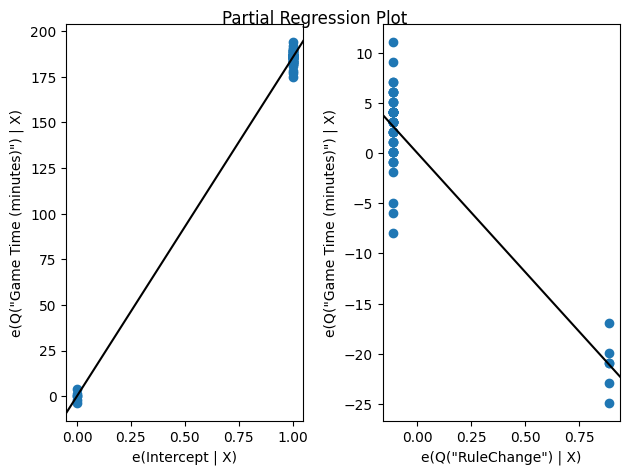

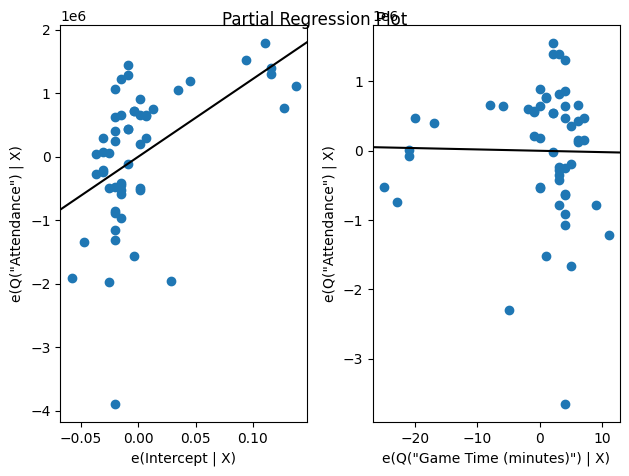

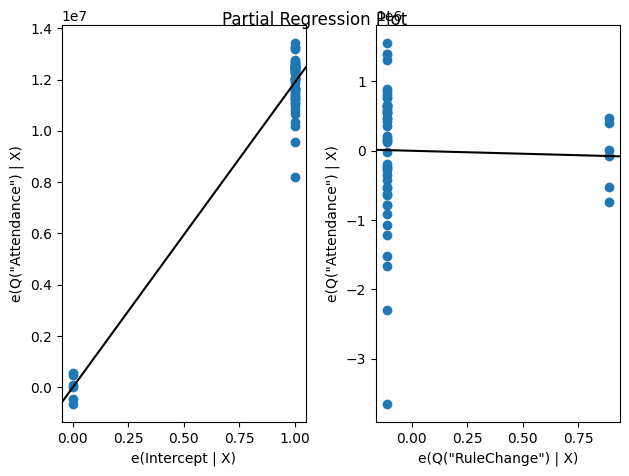

In [8]:
path_analysis.plot_models()